In [400]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cross_validation import train_test_split
from gensim import corpora, models, similarities, matutils

%matplotlib inline

# Limit rows disp# Limit rows displayed in notebook
pd.set_option('display.max_rows', 20)
pd.set_option('display.precision', 6)

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

# About the Data Set
Data is from the [Yelp Dataset Challenge](http://www.yelp.com/dataset_challenge)
+ 1.6M Reviews
+ 500k Tips 
+ 366k Users
+ 61k Businesses + Check ins
    - 481k Business Attributes (hours, parking availability, ambience, etc)    
+ Cities:
    - U.K.: Edinburgh
    - Germany: Karlsruhe
    - Canada: Montreal and Waterloo
    - U.S.: Pittsburgh, Charlotte, Urbana-Champaign, Phoenix, Las Vegas, Madison

####Business
``` 
{
        'type': 'business',
        'business_id': (encrypted business id),
        'name': (business name),
        'neighborhoods': [(hood names)],
        'full_address': (localized address),
        'city': (city),
        'state': (state),
        'latitude': latitude,
        'longitude': longitude,
        'stars': (star rating, rounded to half-stars),
        'review_count': review count,
        'categories': [(localized category names)]
        'open': True / False (corresponds to closed, not business hours),
        'hours': {
            (day_of_week): {
                'open': (HH:MM),
                'close': (HH:MM)
            },
            ...
        },
        'attributes': {
            (attribute_name): (attribute_value),
            ...
        },
    }
```

####Review
```
{
    'type': 'review',
    'business_id': (encrypted business id),
    'user_id': (encrypted user id),
    'stars': (star rating, rounded to half-stars),
    'text': (review text),
    'date': (date, formatted like '2012-03-14'),
    'votes': {(vote type): (count)},
}
```

## Goal: Predict a restaurant's star rating

# Cleaning/Exploring Data
## Business Dataset
+ Turn nested JSON 'attributes' column into boolean features
+ Turn 'categories' column into boolean features
+ Narrow down business set to just restaurants located in Phoenix

In [336]:
phoenix_df = pd.DataFrame(pd.read_pickle('restaurant/phoenix_restaurants.pkl'))
phoenix_df.head()

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,...,cat.Uzbek,cat.Vegan,cat.Vegetarian,cat.Venezuelan,cat.Venues & Event Spaces,cat.Vietnamese,cat.Wedding Planning,cat.Wine Bars,cat.Wineries,cat.Yoga
0,"{u'Take-out': True, u'Accepts Credit Cards': T...",x5Mv61CnZLohZWxfCVCPTQ,"[Sandwiches, Pizza, Chicken Wings, Restaurants]",Phoenix,"2819 N Central Ave\nPhoenix, AZ 85004",{},33.5,-112.1,Domino's Pizza,[],...,0,0,0,0,0,0,0,0,0,0
1,"{u'Take-out': True, u'Noise Level': u'quiet', ...",2ZnCITVa0abGce4gZ6RhIw,"[American (New), Sandwiches, Restaurants]",Phoenix,"1850 N Central Ave\nPhoenix, AZ 85004",{},33.5,-112.1,Viad Tower Restaurants,[],...,0,0,0,0,0,0,0,0,0,0
2,"{u'Alcohol': u'full_bar', u'Price Range': 1, u...",EmzaQR5hQlF0WIl24NxAZA,"[American (New), Nightlife, Dance Clubs, Resta...",Phoenix,"132 E Washington St\nPhoenix, AZ 85004","{u'Sunday': {u'close': u'02:00', u'open': u'21...",33.4,-112.1,Sky Lounge,[],...,0,0,0,0,0,0,0,0,0,0
3,"{u'Take-out': True, u'Accepts Credit Cards': T...",KPoTixdjoJxSqRSEApSAGg,"[Thai, Restaurants]",Phoenix,"2631 N Central Ave\nPhoenix, AZ 85004","{u'Monday': {u'close': u'21:00', u'open': u'11...",33.5,-112.1,Wild Thaiger,[],...,0,0,0,0,0,0,0,0,0,0
4,"{u'Alcohol': u'full_bar', u'Open 24 Hours': Fa...",e5kc0CQ4R-PCCDgb274gSg,"[Mexican, Tex-Mex, Restaurants]",Phoenix,"455 N 3rd St\nSte 114\nPhoenix, AZ 85004","{u'Monday': {u'close': u'21:00', u'open': u'11...",33.5,-112.1,Canyon Cafe,[],...,0,0,0,0,0,0,0,0,0,0


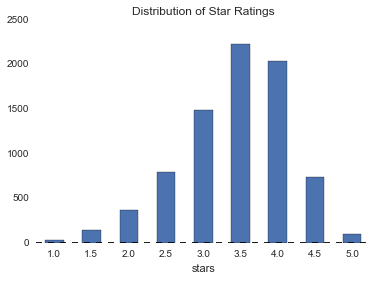

In [338]:
phoenix_df.groupby('stars').stars.count().plot(kind='bar', title='Distribution of Star Ratings', grid=False)
plt.setp(plt.xticks()[1], rotation=0)
remove_border()

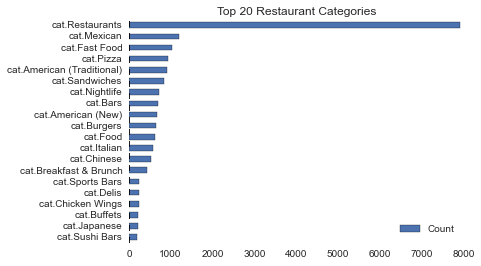

In [339]:
cat = pd.DataFrame(phoenix_df.loc[:, 'cat.Active Life':'cat.Yoga'].sum(), columns=['Count'])
cat = cat[cat['Count']>0]
cat.sort(['Count']).tail(20).plot(kind='barh', title='Top 20 Restaurant Categories', grid=False)
remove_border()

## Review Dataset
+ Narrow down review dataset to reviews for the restaurants in the restaurant dataset
+ Unnest 'votes' column into feature columnes
+ Narrow down business set to just restaurants located in Phoenix
+ Remove outliers based on review count for each restaurant

In [350]:
reviews = pd.read_pickle('review/reviews300k.pkl')
reviews.head()

,business_id,business_id_x,review_id,date.year,date.month,date.day,stars,text,review_length_x,votes.cool,votes.funny,votes.useful,user_id,business_id_y,review_length_y
0,x5Mv61CnZLohZWxfCVCPTQ,x5Mv61CnZLohZWxfCVCPTQ,4ibY4fPQYM7FBSVPrvrYvg,2010,4,2,4,Not the same Domino's pizza I ate too much of ...,375,0,0,0,t95D1tnWvAOy2sxXnI3GUA,x5Mv61CnZLohZWxfCVCPTQ,375
1,x5Mv61CnZLohZWxfCVCPTQ,x5Mv61CnZLohZWxfCVCPTQ,1JlopVxrAeDNQCRnSHLHrQ,2010,5,3,4,Easy ordering-on-line. Made exactly as I asked...,606,0,0,0,t95D1tnWvAOy2sxXnI3GUA,x5Mv61CnZLohZWxfCVCPTQ,606
2,x5Mv61CnZLohZWxfCVCPTQ,x5Mv61CnZLohZWxfCVCPTQ,9--jL__9efnmXZEm9o0HIw,2010,11,2,5,OK OK... as a Proud Italian I hope my momma do...,1722,5,4,4,9ellV9VrEOPA3vX2pZptSA,x5Mv61CnZLohZWxfCVCPTQ,1722
3,x5Mv61CnZLohZWxfCVCPTQ,x5Mv61CnZLohZWxfCVCPTQ,TOZMdEyuVnLfkLt6rlxxGA,2011,6,17,2,"So Domino's is Domino's, right? You must know...",1457,1,2,2,UpcVov-qPEKJk6FXl3LLHA,x5Mv61CnZLohZWxfCVCPTQ,1457
4,x5Mv61CnZLohZWxfCVCPTQ,x5Mv61CnZLohZWxfCVCPTQ,u-LEH9e8mWPVmolbsXb5rg,2012,9,4,3,never has crushed peppers! \n\nbut the pizza a...,60,0,1,1,NkxFV7RefN87jL_LeVlIPg,x5Mv61CnZLohZWxfCVCPTQ,60


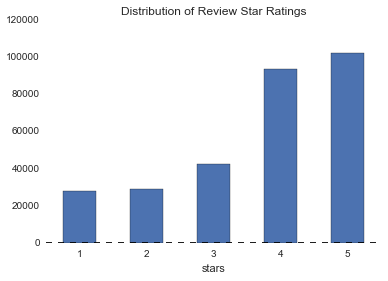

In [342]:
reviews.groupby('stars').stars.count().plot(kind='bar', title='Distribution of Review Star Ratings', grid=False)
plt.setp(plt.xticks()[1], rotation=0)
remove_border()

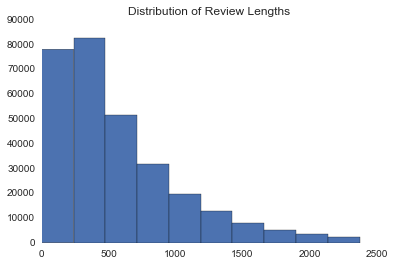

In [344]:
reviews.review_length_x.hist(grid=False)
plt.title('Distribution of Review Lengths')

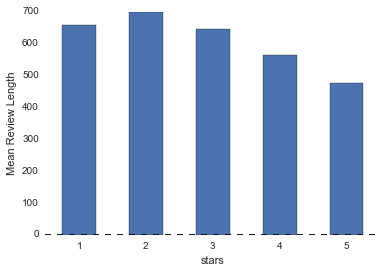

In [346]:
reviews.groupby('stars').review_length_x.mean().plot(kind='bar', rot=0, grid=False)
plt.ylabel('Mean Review Length')

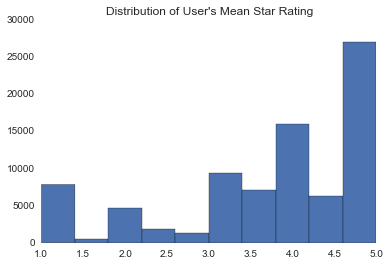

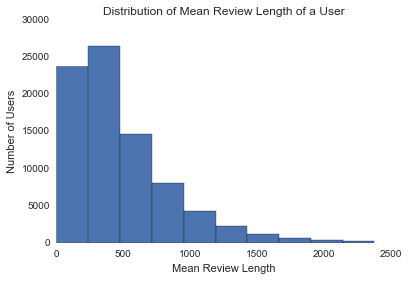

In [349]:
gp_user_mean = reviews.groupby('user_id').mean()
gp_user_mean['stars'].hist();
plt.title("Distribution of User's Mean Star Rating")
plt.show();
plt.xlabel('Mean Star Rating')
plt.ylabel('Number of Users')
gp_user_mean['review_length_x'].hist();
plt.title('Distribution of Mean Review Length of a User')
plt.xlabel('Mean Review Length')
plt.ylabel('Number of Users')
plt.show();

# First Initial Linear Regression Model
+ Features extracted from just the business dataset

In [503]:
# features from just the business data set
X1_1 = X1.loc[:,:'wifi.paid']

run_all_models(X1_1, y)

======================LINEAR REGRESSION======================
HALF INTEGER ROUND

Score as linear regression problem:
Residual sum of squares:
0.259596115461

5-fold cross validation scores:
[ 0.18809425  0.19408245  0.13636728  0.17114252  0.07577891]

Mean Score: 0.153093
-------------------------------------------

Score after converting to multiclass problem:
0.386904761905

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.00      0.00      0.00        31
        3.0       0.29      0.25      0.27       117
        3.5       0.35      0.51      0.42       223
        4.0       0.49      0.50      0.49       227
        4.5       0.25      0.07      0.11        54
        5.0       0.00      0.00      0.00         4

avg / total       0.35      0.39      0.36       672


           predicted                              
                 1.5 2.0 2.5 3.0 

In [285]:
run_and_score(LinearRegression, X1_1, y, cust_round)

Score as linear regression problem:
Residual sum of squares:
0.259596115461

5-fold cross validation scores:
[ 0.18809425  0.19408245  0.13636728  0.17114252  0.07577891]

Mean Score: 0.153093

Score after converting to multiclass problem:
0.619047619048

             precision    recall  f1-score   support

        2.0       0.00      0.00      0.00        16
        3.0       0.38      0.59      0.46       148
        4.0       0.74      0.72      0.73       450
        5.0       0.60      0.05      0.10        58

avg / total       0.63      0.62      0.60       672


           predicted              
                 2.0  3.0  4.0 5.0
actual 2.0         0   11    5   0
       3.0         1   87   60   0
       4.0         0  122  326   2
       5.0         0    7   48   3


# Use LDA to extract more features
+ Unsupervised model that finds latent topics in texts
+ Train model on review documents
+ Model will tell you k topics and what words contribute to that topic
+ Use model to find which topic a review is most likely to belong to and get the probability distribution over the words in the topic
    - ie: topic 1: 10% service, 20% food, 5% time
+ Used set of 10k reviews randomly selected to build the model

### Two ways I built LDA models:
1. Trained model with all 10k reviews
2. Split reviews based on star ratings (1, 2, 3, 4, 5). Then build LDA model for each set of reviews.

#### Method 1

In [353]:
lda_model_50 = models.LdaModel.load('/tmp/model_50.lda')
df = pd.DataFrame(lda_model_50.show_topics(num_topics=50, formatted=False))
df = df.applymap(lambda x: x[1])
lda_columns = map( lambda x: 'word_' + str(x), df.columns.values)
df.columns = lda_columns
df['words'] = map(list, df.values)
df

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,words
0,food,good,service,just,place,time,right,great,restaurant,elements,"[food, good, service, just, place, time, right..."
1,place,really,like,just,good,service,food,great,did,time,"[place, really, like, just, good, service, foo..."
2,food,good,like,lunch,went,didn,service,just,ordered,did,"[food, good, like, lunch, went, didn, service,..."
3,great,place,food,good,thai,staff,service,best,restaurant,just,"[great, place, food, good, thai, staff, servic..."
4,place,bar,food,service,lazy,rum,like,just,tables,great,"[place, bar, food, service, lazy, rum, like, j..."
5,food,good,just,place,great,like,time,really,service,know,"[food, good, just, place, great, like, time, r..."
6,breakfast,food,great,place,hash,pancakes,sausage,hash browns,friendly,lobster,"[breakfast, food, great, place, hash, pancakes..."
7,ordered,mom,food,complimentary,place,dessert,pizza,like,remember,service,"[ordered, mom, food, complimentary, place, des..."
8,place,good,really,great,food,like,got,menu,time,try,"[place, good, really, great, food, like, got, ..."
9,place,food,pho,good,service,like,soup,chicken,great,ve,"[place, food, pho, good, service, like, soup, ..."


In [354]:
r = pd.read_pickle('review/reviews_with_topics.pkl')
r.head()

,business_id,review_id,date.year,date.month,date.day,stars,text,review_length,votes.cool,votes.funny,votes.useful,user_id,topic_id_50,topic_prob_50,word_dist_50
0,E7nk0lC317pGxMX56gvaVQ,onOLEBffcpWS_jcaBLCqdw,2008,6,17,1,This place is a huge waste of the space they m...,1239,3,4,2,eBFm-lABQiKpaUcPDfYOgA,39,0.6,"[(0.00977830773598, place), (0.00650128695031,..."
1,duHUQFn7K-Ybs1rPI4AOEQ,23z4mKkaMCXGFw4cm6xHxA,2012,4,15,3,I used to frequent Z-Tejas more frequently for...,936,1,1,2,y5_vrqIylhXMrejM_-x_vA,43,0.7,"[(0.0090865194881, good), (0.00526586990462, g..."
2,_K5cfCM7-zQZ1hXdbsc2fQ,dqrwXpcYdFvNYL5z1AeuZw,2013,12,1,3,"Meeting some friends for dinner, they live in ...",1119,0,0,0,8si1MT348c-rNZYDWCJvzQ,39,0.6,"[(0.00977830773598, place), (0.00650128695031,..."
3,OTq55xUFMOz13DAi9D0_rw,uiJbTytfC1zsSOQ4aA3AWg,2014,12,23,4,"Good food, and good service",27,0,0,1,YfWmj8wWbuiCbnC6D8gvpw,48,0.9,"[(0.0146616328294, good), (0.0142812265826, fo..."
4,Kfbs3K37ZczrOQnoxgzNkw,II7cxU1cbOxVqzYY4ueflQ,2012,1,25,4,Came here today to get lunch to go. They were ...,661,1,0,2,kffxYQVQsEpF1DVlQlcGCg,5,0.9,"[(0.0063096357766, food), (0.00550394162605, g..."


In [366]:
r.text.values

array([ u"This place is a huge waste of the space they managed to acquire. \n\nThe one and only experience I had here was an all expenses paid work celebration happy hour, and it took all the good-humor I have in my body to have a decent time. It was hard just to stop myself from throwing bottles and stale chips at the staff and other patrons. \n\nThe happy hour was arranged because it was one of the members of our social team's favorite bars. They spent THOUSANDS of dollars to hold an event with a couple of free drinks and some vats of appetizers. All the food was a step down from Applebees at prices that would make even Matt Leinart cry. And the brew selection is absolutely abysmal and has no taps.\n\nI don't understand what it is that drives Scottsdalites to blow a mortgage payment's worth of money each month on hang outs like this with nothing to do but stare at each other with awful domestic bottled beer and frozen Costco appetizers.\n\nThe evening only became notable for how beli

[None, None, None, None, None]

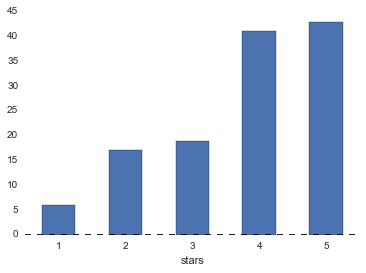

In [365]:
topic_0_reviews = r[r['topic_id_50']==0]
topic_0_reviews.groupby('stars').stars.count().plot(kind='bar')
plt.setp(plt.xticks()[1], rotation=0)

#### Method 2
+ 5 models, 1 for each review set grouped by rating

In [367]:
s1 = pd.read_pickle('by_stars/10ktopics_star_1.pkl')
s2 = pd.read_pickle('by_stars/10ktopics_star_2.pkl')
s3 = pd.read_pickle('by_stars/10ktopics_star_3.pkl')
s4 = pd.read_pickle('by_stars/10ktopics_star_4.pkl')
s5 = pd.read_pickle('by_stars/10ktopics_star_5.pkl')

In [368]:
s1.head()

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,words
0,food,place,order,just,chicken,like,service,went,bad,good,"[food, place, order, just, chicken, like, serv..."
1,food,place,service,good,just,ordered,didn,don,eat,like,"[food, place, service, good, just, ordered, di..."
2,food,time,just,good,order,place,service,say,nice,like,"[food, time, just, good, order, place, service..."
3,food,place,like,time,order,good,just,service,went,burger,"[food, place, like, time, order, good, just, s..."
4,food,good,just,place,service,time,restaurant,chicken,table,bad,"[food, good, just, place, service, time, resta..."


#### 1 Star reviews for topic 1:

In [379]:
star_1 = pd.read_pickle('by_stars/1reviews10k_with_topics.pkl')
star_1[star_1['topic_id']==1].text.values

array([ u'This is a very bad McDonald\'s. They serve dried out sandwiches on stale bread that\'s been sitting around for too long. When made fresh and properly prepared, McDonald\'s food is delicious. What this restaurant does to McDonald\'s is a disgrace and I wish the corporation would deny franchises to "investors" who buy these restaurants and leave unmotivated unprofessional morons to run them.',
       u'First let me say I am in the restaurant business. That being said I HATE to give poor reviews. In this case I have no choice.\nWhen i first walked in I thought : GENERIC Bennigans. Those of you old enough to remember Bennigans restaurants will understand.\n\nTHE SERVICE\n\nSara our server was good. She was very polite and genuine. I appreciated her service. She was the only bright spot.\n\nTHE FOOD \n\nGENERIC, lower quality,  I completely understand that the franchisees in these types of business have zero to next to zero input as far as suppliers and food quality. They are buyi

In [372]:
s5.head()

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,words
0,great,food,good,place,bbq,service,just,time,eat,pork,"[great, food, good, place, bbq, service, just,..."
1,good,meat,time,place,delicious,just,sub,fresh,food,shrimp,"[good, meat, time, place, delicious, just, sub..."
2,great,time,food,really,place,good,favorite,gai,great drinks,great time,"[great, time, food, really, place, good, favor..."
3,place,good,food,best,great,really,pizza,love,like,don,"[place, good, food, best, great, really, pizza..."
4,great,place,food,restaurant,fresh,service,like,good,ve,try,"[great, place, food, restaurant, fresh, servic..."


#### 5 Star reviews for topic 2

In [380]:
star_5 = pd.read_pickle('by_stars/5reviews10k_with_topics.pkl')

star_5[star_5['topic_id']==2].text.values

array([ u"The happy hour here is awesome. Great drinks, great apps menu and there's a corn hole court in the back!",
       u'Love the Tom Ka Gai soup! Love the Pinapple Rice! Consistently pleased when ever I dine here...which is frequently.',
       u'They earned it! The mango berry salad is the bomb. I also get the avocado and crab melted sandwich. Although they still ask you several times "what did you order?" so should really change the process!',
       u'Pacifico on tap! This place is great! They keep it real and the food is great! Kinda old inside but worth going there to eat for sure.',
       u'Fantastic experience.  Our journey began with white fish carpaccio, which was topped with marinated green onions, yuzu, and a tasty broth.  It was delicate and very flavorful.  The next course was three different preparations... one poached shrimp with the head fried, a kumumoto oyster (only one unfortunately), and tuna taretar.  All three were very tasty.  Our third course was A5 kobe 

# Predicting a restaurant's Yelp star rating

### Tried 3 models on 3358 restaurants:
#### Linear Regression
+ Rounded predicted values into:
    - half integers
    - integers
    
#### Ridge Regression
+ Regularized linear regression
+ Rounded predicted values into:
    - half integers
    - integers

#### SVC Classifier
+ Two sets of target labels:
    - half integers
    - integers

### Used 2 sets of features:
#### X1: Business attributes + features extracted from LDA Topic Model (method 1):
+ 374 features (business attributes, topic id, prob of topic)

#### X2: Business attributes + features extracted from LDA Topic Model (method 2):
+ 487 features (business attributes, top 10 words, prob dist over words)

### Tried 3 methods to improve features:
+ reduced dimensions via PCA 
+ removed features with low variance
+ scaled features

In [538]:
results

business_attr_only       X1       X2  \
Linear Regression Half Integer Round             0.38690  0.38244  0.41667   
                  Integer Round                  0.61905  0.64286  0.63542   
Ridge Regression  Half Integer Round             0.38690  0.39137  0.39435   
                  Integer Round                  0.61905  0.64583  0.62202   
SVC               Half Integer Round             0.36986  0.33174  0.35199   
                  Integer Round                  0.66230  0.65694  0.66170   

                                       pca_X1   pca_X2  reduced_X1  \
Linear Regression Half Integer Round  0.36012  0.36012     0.38839   
                  Integer Round       0.63988  0.63988     0.59821   
Ridge Regression  Half Integer Round  0.36012  0.36012     0.38839   
                  Integer Round       0.63988  0.63988     0.59821   
SVC               Half Integer Round  0.36091  0.36091     0.32636   
                  Integer Round       0.66170  0.66170     0.65099   

                                      reduced_X2  scaled_X1  scaled_X2  
Linear Regression Half Integer Round     0.39583    0.38690    0.40476  
                  Integer Round          0.60565    0.61607    0.61458  
Ridge Regression  Half Integer Round     0.39583    0.38690    0.40476  
                  Integer Round          0.60565    0.61607    0.61458  
SVC               Half Integer Round     0.33650    0.38589    0.41004  
                  Integer Round          0.65634    0.67808    0.67808

### Highest Scoring Model: SVM Classifier with scaled features, 67.808% accuracy rate
### Some observations:
+ In general, X2 feature set resulted in slightly higher scores than X1.
+ Removing features with low variance resulted in slightly worse scores.
+ Scaling features was optimal for SVC classifier


### Next steps:
+ Improve feature set by adding more features that might help distinguish 3 star and 4 star rated restaurants
+ Add features based on combination of topic + sentiment
+ Try other classifiers


In [141]:
restaurants1 = pd.read_pickle('restaurant/restaurant_with_topic_dist1.pkl')
restaurants2 = pd.read_pickle('by_stars/restaurant_with_topic_dist1.pkl')


In [142]:
restaurants1.head()

,business_id,open,review_count,stars,cat.Active Life,cat.Adult Entertainment,cat.Afghan,cat.African,cat.Airports,cat.American (New),...,avg_topic_41,avg_topic_42,avg_topic_43,avg_topic_44,avg_topic_45,avg_topic_46,avg_topic_47,avg_topic_48,avg_topic_49,avg_business_id
0,EmzaQR5hQlF0WIl24NxAZA,1,23,2.5,0,0,0,0,0,1,...,0.0,0,0,0,0,0.0,0,0.0,0.0,EmzaQR5hQlF0WIl24NxAZA
1,KPoTixdjoJxSqRSEApSAGg,1,322,4.0,0,0,0,0,0,0,...,0.0,0,0,0,0,0.0,0,0.0,0.0,KPoTixdjoJxSqRSEApSAGg
2,e5kc0CQ4R-PCCDgb274gSg,1,191,3.5,0,0,0,0,0,0,...,0.0,0,0,0,0,0.1,0,0.1,0.0,e5kc0CQ4R-PCCDgb274gSg
3,45puCRQ6Vh_IIAy7kkfFDQ,1,170,3.5,0,0,0,0,0,0,...,0.0,0,0,0,0,0.0,0,0.0,0.0,45puCRQ6Vh_IIAy7kkfFDQ
4,BESmH-lmMm34_EefL8X9fQ,1,204,4.0,0,0,0,0,0,0,...,0.1,0,0,0,0,0.0,0,0.1,0.1,BESmH-lmMm34_EefL8X9fQ


In [143]:
restaurants2.head()

,business_id,open,review_count,stars_x,cat.Active Life,cat.Adult Entertainment,cat.Afghan,cat.African,cat.Airports,cat.American (New),...,wait_x,walked_x,want_x,wasn_x,way_x,went_x,wife_x,wine_x,wings_x,yum_x
0,EmzaQR5hQlF0WIl24NxAZA,1,23,2.5,0,0,0,0,0,1,...,0,0,0,0.0e+00,1.8e-03,0,0.0e+00,0,0,0
1,KPoTixdjoJxSqRSEApSAGg,1,322,4.0,0,0,0,0,0,0,...,0,0,0,0.0e+00,0.0e+00,0,2.5e-04,0,0,0
2,e5kc0CQ4R-PCCDgb274gSg,1,191,3.5,0,0,0,0,0,0,...,0,0,0,0.0e+00,0.0e+00,0,0.0e+00,0,0,0
3,45puCRQ6Vh_IIAy7kkfFDQ,1,170,3.5,0,0,0,0,0,0,...,0,0,0,0.0e+00,0.0e+00,0,0.0e+00,0,0,0
4,BESmH-lmMm34_EefL8X9fQ,1,204,4.0,0,0,0,0,0,0,...,0,0,0,2.8e-04,0.0e+00,0,0.0e+00,0,0,0


In [147]:
y = restaurants1.stars
y_labels = y.astype(str)
X1 = restaurants1.copy()
del X1['stars']
del X1['business_id']
del X1['avg_business_id']
del X1['avg_stars']
X1.head()

,open,review_count,cat.Active Life,cat.Adult Entertainment,cat.Afghan,cat.African,cat.Airports,cat.American (New),cat.American (Traditional),cat.Amusement Parks,...,avg_topic_40,avg_topic_41,avg_topic_42,avg_topic_43,avg_topic_44,avg_topic_45,avg_topic_46,avg_topic_47,avg_topic_48,avg_topic_49
0,1,23,0,0,0,0,0,1,0,0,...,0,0.0,0,0,0,0,0.0,0,0.0,0.0
1,1,322,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0.0,0,0.0,0.0
2,1,191,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0.1,0,0.1,0.0
3,1,170,0,0,0,0,0,0,1,0,...,0,0.0,0,0,0,0,0.0,0,0.0,0.0
4,1,204,0,0,0,0,0,0,0,0,...,0,0.1,0,0,0,0,0.0,0,0.1,0.1


In [150]:
X2 = restaurants2.copy()
del X2['business_id']
#del X2['stars_x']
X2.head()

,open,review_count,cat.Active Life,cat.Adult Entertainment,cat.Afghan,cat.African,cat.Airports,cat.American (New),cat.American (Traditional),cat.Amusement Parks,...,wait_x,walked_x,want_x,wasn_x,way_x,went_x,wife_x,wine_x,wings_x,yum_x
0,1,23,0,0,0,0,0,1,0,0,...,0,0,0,0.0e+00,1.8e-03,0,0.0e+00,0,0,0
1,1,322,0,0,0,0,0,0,0,0,...,0,0,0,0.0e+00,0.0e+00,0,2.5e-04,0,0,0
2,1,191,0,0,0,0,0,0,0,0,...,0,0,0,0.0e+00,0.0e+00,0,0.0e+00,0,0,0
3,1,170,0,0,0,0,0,0,1,0,...,0,0,0,0.0e+00,0.0e+00,0,0.0e+00,0,0,0
4,1,204,0,0,0,0,0,0,0,0,...,0,0,0,2.8e-04,0.0e+00,0,0.0e+00,0,0,0


In [506]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_validation import cross_val_score
from math import ceil
from sklearn import svm, metrics, tree
from sklearn.metrics import confusion_matrix

def get_rss(lin_model, X_test, y_test):
    predicted = lin_model.predict(X_test)
    print 'Residual sum of squares:'
    print np.mean((predicted - y_test) ** 2)
    return

def get_score(lin_model, X_test, y_test):
    print 'Score:'
    print lin_model.score(X_test, y_test)
    return

def get_cross_val_score(lin_model, X, y):
    scores = cross_val_score(lin_model, X, y, cv=5)
    print "5-fold cross validation scores:"
    print scores
    print
    print "Mean Score: %f" % scores.mean()
    return

def get_coef_matrix(lin_model, X):
    coef_= pd.DataFrame(zip(X.columns.values, lin_model.coef_), columns=['Features', 'Coefficient'])
    return coef_.sort(columns='Coefficient',ascending=False).head(10)

def cust_round_half(x):
    if x < 0:
        return 1.0
    elif x >= 5:
        return 5.0
    elif x % 1 >= 0.7:
        return round(x)
    elif x % 1 >= 0.5:
        return round(x) - 0.5
    elif x % 1 >= 0.3:
        return round(x) + 0.5
    else:
        return round(x)

def cust_round(x):
    if x < 0:
        return 1.0
    elif x >= 5:
        return 5.0
    else:
        return round(x)
    
    
def run_and_score(model, X, y,round_method):
    y_labels = y.astype(str)
    
    if model == Ridge:
        mod = model(alpha=.5)
    else:
        mod = model()
    if model == Ridge or model == LinearRegression:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
        mod.fit(X_train, y_train)
        print 'Score as linear regression problem:'
        get_rss(mod, X_test, y_test)
        print
        get_cross_val_score(mod, X, y)
        print '-------------------------------------------'
        print
        print 'Score after converting to multiclass problem:'
        predicted_labels = map(lambda x : str(round_method(x)), mod.predict(X_test))
        if round_method == cust_round_half:
            y_test_labels = map(lambda x: str(x), y_test)
            categories = sorted(list(set(np.append(np.unique(y_test),(np.unique(predicted_labels))))))
        else:
            y_test_labels = map(lambda x: str(round_method(x)), y_test)
            y_test_cats = map(lambda x: round_method(x), y_test)
            categories = sorted(list(set(np.append(np.unique(y_test_cats),(np.unique(predicted_labels))))))
        
        print metrics.accuracy_score(y_test_labels, predicted_labels)
        print
        print metrics.classification_report(y_test_labels, predicted_labels)
        print
        print pd.DataFrame(confusion_matrix(y_test_labels, predicted_labels),
             index = pd.MultiIndex.from_product([['actual'], categories]),
             columns = pd.MultiIndex.from_product([['predicted'], categories]))
    else:
        y_labels = map(lambda x: str(round_method(x)), y)
        categories = np.unique(y_labels)
        X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=12)
        mod.fit(X_train, y_train)
        get_cross_val_score(mod, X, y_labels)
        predicted = mod.predict(X_test)
        print
        print metrics.classification_report(y_test, predicted)
        print
        print pd.DataFrame(confusion_matrix(y_test, predicted),
             index = pd.MultiIndex.from_product([['actual'], categories]),
             columns = pd.MultiIndex.from_product([['predicted'], categories]))
    
def run_all_models(X, y):
    print '======================LINEAR REGRESSION======================'
    print 'HALF INTEGER ROUND'
    print
    run_and_score(LinearRegression, X, y, cust_round_half)
    print 
    print 'INTEGER ROUND'
    run_and_score(LinearRegression, X, y, cust_round)
    print
    print '======================RIDGE REGRESSION======================'
    print 'HALF INTEGER ROUND'
    print
    run_and_score(LinearRegression, X, y, cust_round_half)
    print 
    print 'INTEGER ROUND'
    run_and_score(LinearRegression, X, y, cust_round)
    print
    print '======================SVC CLASSIFIER======================'
    print 'HALF INTEGER ROUND'
    print
    run_and_score(svm.SVC, X, y, cust_round_half)
    print 
    print 'INTEGER ROUND'
    run_and_score(svm.SVC, X, y, cust_round)

In [426]:
run_all_models(X1, y)

-------------------LINEAR REGRESSION-------------------
HALF INTEGER ROUND

Score as linear regression problem:
Residual sum of squares:
0.259602182393

5-fold cross validation scores:
[ 0.20790232  0.19832582  0.11594976  0.18559797  0.04841539]

Mean Score: 0.151238

Score after converting to multiclass problem:
0.38244047619

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.25      0.03      0.06        31
        3.0       0.28      0.25      0.26       117
        3.5       0.35      0.48      0.40       223
        4.0       0.50      0.49      0.50       227
        4.5       0.28      0.13      0.18        54
        5.0       0.00      0.00      0.00         4

avg / total       0.37      0.38      0.36       672


           predicted                              
                 1.5 2.0 2.5 3.0  3.5  4.0 4.5 5.0
actual 1.5         0   0   0   1 

In [427]:
run_all_models(X2, y)

-------------------LINEAR REGRESSION-------------------
HALF INTEGER ROUND

Score as linear regression problem:
Residual sum of squares:
0.223326481628

5-fold cross validation scores:
[ 0.27719982  0.27047651  0.17729932  0.27096093  0.22098012]

Mean Score: 0.243383

Score after converting to multiclass problem:
0.416666666667

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.00      0.00      0.00        31
        3.0       0.30      0.34      0.32       117
        3.5       0.37      0.38      0.38       223
        4.0       0.52      0.63      0.57       227
        4.5       0.52      0.22      0.31        54
        5.0       0.00      0.00      0.00         4

avg / total       0.39      0.42      0.40       672


           predicted                             
                 1.5 2.0 2.5 3.0 3.5  4.0 4.5 5.0
actual 1.5         0   0   0   3  

## PCA

In [406]:
from sklearn.decomposition import PCA
from itertools import cycle
from seaborn import plt

def plot_PCA_2D(data, target, target_names):
    colors = cycle('rgbcmykw')
    target_ids = range(len(target_names))
    plt.figure()
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label)
    plt.legend()
    
pca = PCA(n_components=2, whiten=True)
pca.fit(X1)

PCA(copy=True, n_components=2, whiten=True)

In [295]:
pca.components_

array([[ -2.00484442e-07,   7.96022308e-05,   2.65772291e-08,
          0.00000000e+00,   2.51772581e-09,   1.51585720e-09,
         -1.85554742e-35,   1.53624113e-07,   6.98111163e-08,
          1.56600415e-09,  -3.34911942e-10,   1.98660989e-09,
         -5.14198226e-09,   2.40715860e-09,   0.00000000e+00,
          0.00000000e+00,  -1.03277492e-08,  -7.30042054e-09,
          0.00000000e+00,   0.00000000e+00,   1.99895628e-09,
         -2.64061459e-08,   1.98521755e-08,   0.00000000e+00,
          7.30390873e-08,   1.64857694e-07,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   4.82350292e-09,
          0.00000000e+00,   8.42379723e-10,   0.00000000e+00,
         -1.45029651e-09,   7.43749971e-09,   0.00000000e+00,
          5.99998625e-09,  -1.42226698e-08,  -8.24214632e-09,
         -1.67999319e-09,  -4.17212407e-09,   1.83965947e-08,
         -9.87370891e-08,   0.00000000e+00,   1.50319220e-09,
          1.70948555e-08,   0.00000000e+00,   2.08435298e-08,
        

In [407]:
pca.explained_variance_ratio_

array([ 0.95403759,  0.04482022])

In [408]:
pca.explained_variance_ratio_.sum()

0.99885780683388026

In [409]:
X1_pca = pca.transform(X1)

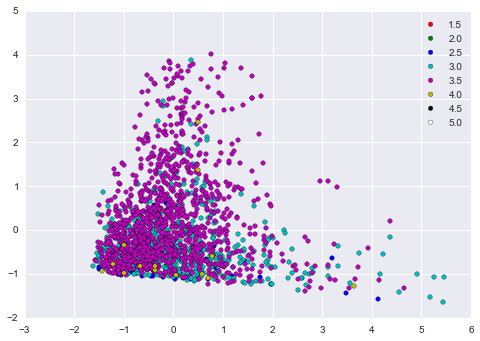

In [301]:
y_target_names = np.unique(y.values)
plot_PCA_2D(X1_pca, y.values, y_target_names)

In [410]:
pca = PCA(n_components=2, whiten=True)
pca.fit(X2)
print pca.explained_variance_ratio_
print pca.explained_variance_ratio_.sum()
X2_pca = pca.transform(X2)



[ 0.95467721  0.04485032]
0.999527529769


In [491]:
run_all_models(X1_pca, y)

======================LINEAR REGRESSION======================
HALF INTEGER ROUND

Score as linear regression problem:
Residual sum of squares:
0.300233351052

5-fold cross validation scores:
[ 0.07879513  0.04575126  0.05896008  0.04900439 -0.0700527 ]

Mean Score: 0.032492
-------------------------------------------

Score after converting to multiclass problem:
0.360119047619

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.00      0.00      0.00        31
        3.0       0.00      0.00      0.00       117
        3.5       0.33      0.77      0.46       223
        4.0       0.45      0.31      0.37       227
        4.5       0.00      0.00      0.00        54
        5.0       0.00      0.00      0.00         4

avg / total       0.26      0.36      0.28       672


           predicted                             
                 1.5 2.0 2.5 3.0  

In [492]:
run_all_models(X2_pca, y)


======================LINEAR REGRESSION======================
HALF INTEGER ROUND

Score as linear regression problem:
Residual sum of squares:
0.300233486547

5-fold cross validation scores:
[ 0.07879531  0.04574761  0.05896098  0.049007   -0.07004997]

Mean Score: 0.032492
-------------------------------------------

Score after converting to multiclass problem:
0.360119047619

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.00      0.00      0.00        31
        3.0       0.00      0.00      0.00       117
        3.5       0.33      0.77      0.46       223
        4.0       0.45      0.31      0.37       227
        4.5       0.00      0.00      0.00        54
        5.0       0.00      0.00      0.00         4

avg / total       0.26      0.36      0.28       672


           predicted                             
                 1.5 2.0 2.5 3.0  

## Remove features with low variance

In [312]:
# remove features with very low variance ie they have the same value in all samples
from sklearn.feature_selection import VarianceThreshold

X1_bools = X1.drop(X.columns[1], axis=1)
X2_bools = X2.drop(X.columns[1], axis=1)
del X1_bools['Price Range_y']
X1_bools = X1_bools.loc[:, :'wifi.paid']

sel1 = VarianceThreshold(threshold=(.9*(1-.9)))
reduced1 = sel1.fit_transform(X1_bools)
sel1.get_support(indices=True)

array([  0,   7,  24, 164, 170, 182, 246, 255, 258, 270, 271, 274, 276,
       277, 278, 279, 288, 290, 300, 301, 302, 306, 308, 310, 311, 312,
       313, 314])

In [313]:
X1_reduced_var = X1.iloc[:, [  0, 1, 7,  24, 164, 170, 182, 246, 255, 258, 270, 271, 274, 276,
       277, 278, 279, 288, 290, 300, 301, 302, 306, 308, 310, 311, 312,
       313, 314]]
X1_reduced = pd.concat([X1_reduced_var, X1.loc[:, 'avg_review_length':]], axis=1)
X1_reduced            

,open,review_count,cat.American (New),cat.Barbeque,cat.Mediterranean,cat.Music Venues,cat.Pita,Accepts Credit Cards_y,Ambience.upscale_y,Corkage_y,...,avg_topic_40,avg_topic_41,avg_topic_42,avg_topic_43,avg_topic_44,avg_topic_45,avg_topic_46,avg_topic_47,avg_topic_48,avg_topic_49
0,1,23,1,0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.0,0,0.0,0.0
1,1,322,0,0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.0,0,0.0,0.0
2,1,191,0,0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.1,0,0.1,0.0
3,1,170,0,0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.0,0,0.0,0.0
4,1,204,0,0,0,0,0,1,0,0,...,0,0.1,0,0.0,0,0,0.0,0,0.1,0.1
5,1,73,0,0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.0,0,0.0,0.0
6,1,152,0,0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.0,0,0.0,0.0
7,0,77,1,0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.0,0,0.0,0.0
8,0,59,0,0,1,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.0,0,0.0,0.0
9,1,105,0,0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0,0.0,0,0.0,0.0


In [316]:
X2_bools = X2.drop(X.columns[1], axis=1)
del X2_bools['Price Range_y']
X2_bools = X2_bools.loc[:, :'wifi.paid']

sel2 = VarianceThreshold(threshold=(.9*(1-.9)))
reduced2 = sel2.fit_transform(X2_bools)
sel2.get_support(indices=True)

array([  0,   7,  24, 164, 170, 182, 246, 255, 258, 270, 271, 274, 276,
       277, 278, 279, 288, 290, 300, 301, 302, 306, 308, 310, 311, 312,
       313, 314])

In [320]:
X2_reduced_var = X1.iloc[:, [  0,   7,  24, 164, 170, 182, 246, 255, 258, 270, 271, 274, 276,
       277, 278, 279, 288, 290, 300, 301, 302, 306, 308, 310, 311, 312,
       313, 314]]
X2_reduced = pd.concat([X2_reduced_var, X2.loc[:, 'review_length_x':]], axis=1)
X2_reduced 

,open,cat.American (New),cat.Barbeque,cat.Mediterranean,cat.Music Venues,cat.Pita,Accepts Credit Cards_y,Ambience.upscale_y,Corkage_y,Good For Groups_y,...,wait_x,walked_x,want_x,wasn_x,way_x,went_x,wife_x,wine_x,wings_x,yum_x
0,1,1,0,0,0,0,1,0,0,1,...,0,0,0,0.0e+00,1.8e-03,0,0.0e+00,0,0,0
1,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0.0e+00,0.0e+00,0,2.5e-04,0,0,0
2,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0.0e+00,0.0e+00,0,0.0e+00,0,0,0
3,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0.0e+00,0.0e+00,0,0.0e+00,0,0,0
4,1,0,0,0,0,0,1,0,0,1,...,0,0,0,2.8e-04,0.0e+00,0,0.0e+00,0,0,0
5,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0.0e+00,0.0e+00,0,0.0e+00,0,0,0
6,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0.0e+00,0.0e+00,0,0.0e+00,0,0,0
7,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0.0e+00,0.0e+00,0,0.0e+00,0,0,0
8,0,0,0,1,0,0,1,0,0,1,...,0,0,0,0.0e+00,0.0e+00,0,0.0e+00,0,0,0
9,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0.0e+00,0.0e+00,0,0.0e+00,0,0,0


In [493]:
run_all_models(X1_reduced, y)

======================LINEAR REGRESSION======================
HALF INTEGER ROUND

Score as linear regression problem:
Residual sum of squares:
0.267022621171

5-fold cross validation scores:
[ 0.13556461  0.11851783  0.13385746  0.14350589  0.02332677]

Mean Score: 0.110955
-------------------------------------------

Score after converting to multiclass problem:
0.388392857143

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.50      0.03      0.06        31
        3.0       0.32      0.19      0.24       117
        3.5       0.35      0.57      0.43       223
        4.0       0.47      0.48      0.47       227
        4.5       0.44      0.07      0.13        54
        5.0       0.00      0.00      0.00         4

avg / total       0.39      0.39      0.36       672


           predicted                              
                 1.5 2.0 2.5 3.0 

In [494]:
run_all_models(X2_reduced, y)

======================LINEAR REGRESSION======================
HALF INTEGER ROUND

Score as linear regression problem:
Residual sum of squares:
0.240641202708

5-fold cross validation scores:
[ 0.18806564  0.19500658  0.14183686  0.25095342  0.21185028]

Mean Score: 0.197543
-------------------------------------------

Score after converting to multiclass problem:
0.395833333333

             precision    recall  f1-score   support

        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.00      0.00      0.00        31
        3.0       0.32      0.30      0.31       117
        3.5       0.36      0.43      0.40       223
        4.0       0.46      0.56      0.51       227
        4.5       0.56      0.09      0.16        54
        5.0       1.00      0.25      0.40         4

avg / total       0.38      0.40      0.37       672


           predicted                             
                 1.5 2.0 2.5 3.0 3

## Scaled features

In [420]:
from sklearn import preprocessing
X1_scaled = preprocessing.scale(X1)
X2_scaled = preprocessing.scale(X2)

In [495]:
run_all_models(X1_scaled, y)

======================LINEAR REGRESSION======================
HALF INTEGER ROUND

Score as linear regression problem:
Residual sum of squares:
1.19736200795e+27

5-fold cross validation scores:
[ -3.15733393e+27  -2.83652198e+27  -1.51901927e+28  -1.04111425e+28
  -5.29895230e+27]

Mean Score: -7378828690774937172682211328.000000
-------------------------------------------

Score after converting to multiclass problem:
0.386904761905

             precision    recall  f1-score   support

        1.0       0.00      0.00      0.00         0
        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.50      0.03      0.06        31
        3.0       0.30      0.30      0.30       117
        3.5       0.35      0.45      0.39       223
        4.0       0.51      0.50      0.50       227
        4.5       0.32      0.15      0.20        54
        5.0       0.09      0.25      0.13         4

avg / total       0.39      0

In [496]:
run_all_models(X2_scaled, y)

======================LINEAR REGRESSION======================
HALF INTEGER ROUND

Score as linear regression problem:
Residual sum of squares:
1.02673862043e+27

5-fold cross validation scores:
[ -6.73190013e+27  -1.60339739e+27  -4.00046618e+27  -8.21975668e+27
  -4.58387313e+27]

Mean Score: -5027878699905308822719168512.000000
-------------------------------------------

Score after converting to multiclass problem:
0.404761904762

             precision    recall  f1-score   support

        1.0       0.00      0.00      0.00         0
        1.5       0.00      0.00      0.00         3
        2.0       0.00      0.00      0.00        13
        2.5       0.00      0.00      0.00        31
        3.0       0.33      0.38      0.35       117
        3.5       0.37      0.37      0.37       223
        4.0       0.51      0.59      0.54       227
        4.5       0.43      0.19      0.26        54
        5.0       0.00      0.00      0.00         4

avg / total       0.38      0

In [504]:
results.max()

X1            0.65694
X2            0.66170
pca_X1        0.66170
pca_X2        0.66170
reduced_X1    0.65099
reduced_X2    0.65634
scaled_X1     0.67808
scaled_X2     0.67808
dtype: float64

In [532]:
arrays = [np.array(['Linear Regression', 'Linear Regression', 'Ridge Regression', 'Ridge Regression','SVC', 'SVC']),
         np.array(['Half Integer Round', 'Integer Round', 'Half Integer Round', 'Integer Round', 'Half Integer Round', 'Integer Round'])]

X1_scores = [0.38244047619, 0.642857142857, 0.391369047619, 0.645833333333, 0.331737, 0.656944]

results = pd.DataFrame(X1_scores, index=arrays, columns=['X1'])
results['X2'] = [0.416666666667, 0.635416666667, 0.394345238095, 0.622023809524, 0.351986, 0.661705] 
results['pca_X1'] = [0.360119047619, 0.639880952381, 0.360119047619, 0.639880952381, 0.360908, 0.661703]

results['pca_X2'] = [0.360119047619, 0.639880952381, 0.360119047619, 0.639880952381, 0.360908, 0.661703]

results['reduced_X1'] = [0.388392857143, 0.598214285714, 0.388392857143, 0.598214285714, 0.326361, 0.650988]

results['reduced_X2'] =[0.395833333333, 0.605654761905, 0.395833333333, 0.605654761905, 0.336499, 0.656340]
results['scaled_X1'] = [0.386904761905, 0.616071428571, 0.386904761905, 0.616071428571, 0.385890, 0.678077]
results['scaled_X2'] =[0.404761904762, 0.614583333333, 0.404761904762, 0.614583333333, 0.410044, 0.678077]
results

X1       X2   pca_X1   pca_X2  \
Linear Regression Half Integer Round  0.38244  0.41667  0.36012  0.36012   
                  Integer Round       0.64286  0.63542  0.63988  0.63988   
Ridge Regression  Half Integer Round  0.39137  0.39435  0.36012  0.36012   
                  Integer Round       0.64583  0.62202  0.63988  0.63988   
SVC               Half Integer Round  0.33174  0.35199  0.36091  0.36091   
                  Integer Round       0.65694  0.66170  0.66170  0.66170   

                                      reduced_X1  reduced_X2  scaled_X1  \
Linear Regression Half Integer Round     0.38839     0.39583    0.38690   
                  Integer Round          0.59821     0.60565    0.61607   
Ridge Regression  Half Integer Round     0.38839     0.39583    0.38690   
                  Integer Round          0.59821     0.60565    0.61607   
SVC               Half Integer Round     0.32636     0.33650    0.38589   
                  Integer Round          0.65099     0.65634    0.67808   

                                      scaled_X2  
Linear Regression Half Integer Round    0.40476  
                  Integer Round         0.61458  
Ridge Regression  Half Integer Round    0.40476  
                  Integer Round         0.61458  
SVC               Half Integer Round    0.41004  
                  Integer Round         0.67808

In [533]:
results['business_attr_only'] = [0.386904761905, 0.619047619048, 0.386904761905, 0.619047619048, 0.369865, 0.662301]
results

X1       X2   pca_X1   pca_X2  \
Linear Regression Half Integer Round  0.38244  0.41667  0.36012  0.36012   
                  Integer Round       0.64286  0.63542  0.63988  0.63988   
Ridge Regression  Half Integer Round  0.39137  0.39435  0.36012  0.36012   
                  Integer Round       0.64583  0.62202  0.63988  0.63988   
SVC               Half Integer Round  0.33174  0.35199  0.36091  0.36091   
                  Integer Round       0.65694  0.66170  0.66170  0.66170   

                                      reduced_X1  reduced_X2  scaled_X1  \
Linear Regression Half Integer Round     0.38839     0.39583    0.38690   
                  Integer Round          0.59821     0.60565    0.61607   
Ridge Regression  Half Integer Round     0.38839     0.39583    0.38690   
                  Integer Round          0.59821     0.60565    0.61607   
SVC               Half Integer Round     0.32636     0.33650    0.38589   
                  Integer Round          0.65099     0.65634    0.67808   

                                      scaled_X2  business_attr_only  
Linear Regression Half Integer Round    0.40476             0.38690  
                  Integer Round         0.61458             0.61905  
Ridge Regression  Half Integer Round    0.40476             0.38690  
                  Integer Round         0.61458             0.61905  
SVC               Half Integer Round    0.41004             0.36986  
                  Integer Round         0.67808             0.66230